In [1]:
#for data analysis and modeling
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing import text, sequence 
from tensorflow.keras.models import Sequential, model_from_json
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
#for text cleaning
import string
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#for visualization
import matplotlib.pyplot as plt

In [13]:
# Get Data and store on a Pandas Dataframe.

df = pd.read_csv('clean.csv')

# Check to make sure we only have positive and negative labels. Once done,
# We can convert to categorical data.

assert set(df['injury_report'].values) == set([0, 1])

df.injury_report = pd.Categorical(df.injury_report)
df['injury_report'] = df['injury_report'].cat.codes
df = df.dropna()

# We only desire the tweet and the injury report columns, so let's
# eliminate the others.

df_new = df[["tweet", "injury_report"]]
df_new1 = df_new[df_new['injury_report']==0]
df_new2 = df_new[df_new['injury_report']==1]

df_new1 = df_new1.sample(4*len(df_new2), replace = True)
df_new = pd.concat([df_new1,df_new2])

df_new.reset_index(drop = True, inplace = True)

# Split the Data into training and test sets.

X_train, X_test, y_train, y_test = train_test_split(df_new['tweet'], 
                                                    df_new['injury_report'], 
                                                   random_state = 91, 
                                                    stratify = df_new['injury_report'], 
                                                    test_size = 0.2)

train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

train, test = train_test_split(df_new, random_state=91)

print(train.shape)
print(test.shape)

(10230, 2)
(3410, 2)


In [14]:
X_train, y_train = train['tweet'], train['injury_report']
X_test, y_test = test['tweet'], test['injury_report']

max_len = X_train.apply(lambda x: len(x)).max()

max_words = 10000
tokenizer = text.Tokenizer(num_words = max_words)
# create the vocabulary by fitting on x_train text
tokenizer.fit_on_texts(X_train)
# generate the sequence of tokens
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# pad the sequences
X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=max_len)
word_index = tokenizer.word_index

In [15]:
embedding_vectors = {}

with open('glove.42B.300d.txt','r',encoding='utf-8') as file:
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights

#initialize the embedding_matrix with zeros
emb_dim = 300
if max_words is not None: 
    vocab_len = max_words 
else:
    vocab_len = len(word_index)+1
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1 
            oov_words.append(word)
#print some of the out of vocabulary words
print(f'Some out of valubulary words: {oov_words[0:5]}')
print(f'{oov_count} out of {vocab_len} words were OOV.')

Some out of valubulary words: ['covid', 'it’s', 'he’s', 'i’m', "tonight's"]
2190 out of 10000 words were OOV.


In [16]:
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
lstm_model.add(LSTM(128, return_sequences=False))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation = 'sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())

batch_size = 256
epochs  = 10
history = lstm_model.fit(X_train_pad, np.asarray(y_train), 
                         validation_data=(X_test_pad, np.asarray(y_test)), 
                         batch_size = batch_size, 
                         epochs = epochs)

confusion_matrix(np.asarray(y_test), lstm_model.predict(X_test_pad) > 0.5)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 3,219,777
Trainable params: 219,777
Non-trainable params: 3,000,000
_________________________________________________________________
None
Epoch 1/10
40/40 [==============================] - 199s 5s/step - loss: 0.4221 - accuracy: 0.8326 - val_loss: 0.2470 - val_accuracy: 0.9094
Epoch 2/10
40/40 [==============================] - 211s 5s/step - loss: 0.1908 - accuracy

array([[2651,   43],
       [  71,  645]], dtype=int64)

Text(0.5, 1.0, 'Accuracy')

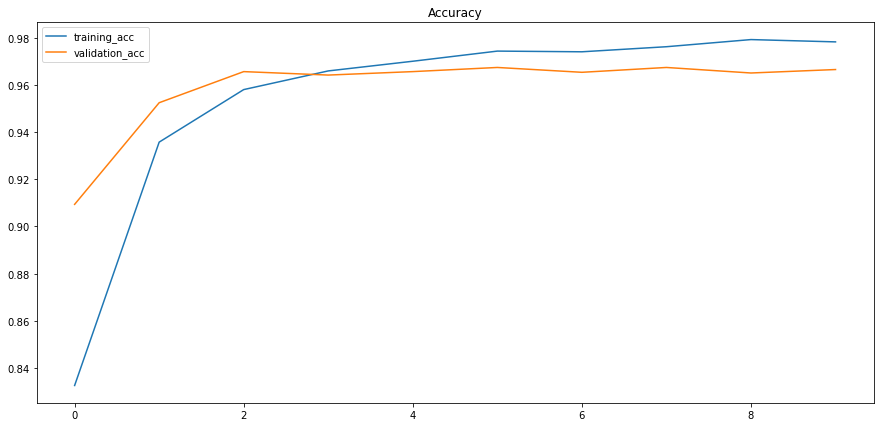

In [17]:
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

In [18]:
emb_dim = embedding_matrix.shape[1]
gru_model = Sequential()
gru_model.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
gru_model.add(GRU(128, return_sequences=False))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(1, activation = 'sigmoid'))
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru_model.summary())

batch_size = 256
epochs  = 10
history = gru_model.fit(X_train_pad, np.asarray(y_train), 
                        validation_data=(X_test_pad, np.asarray(y_test)), 
                        batch_size = batch_size, epochs = epochs)

confusion_matrix(np.asarray(y_test), gru_model.predict(X_test_pad) > 0.5)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               165120    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 3,165,249
Trainable params: 165,249
Non-trainable params: 3,000,000
_________________________________________________________________
None
Epoch 1/10
40/40 [==============================] - 260s 6s/step - loss: 0.4902 - accuracy: 0.7976 - val_loss: 0.4069 - val_accuracy: 0.8340
Epoch 2/10
40/40 [==============================] - 234s 6s/step - loss: 0.2498 - accuracy

array([[2654,   40],
       [  65,  651]], dtype=int64)

Text(0.5, 1.0, 'Accuracy')

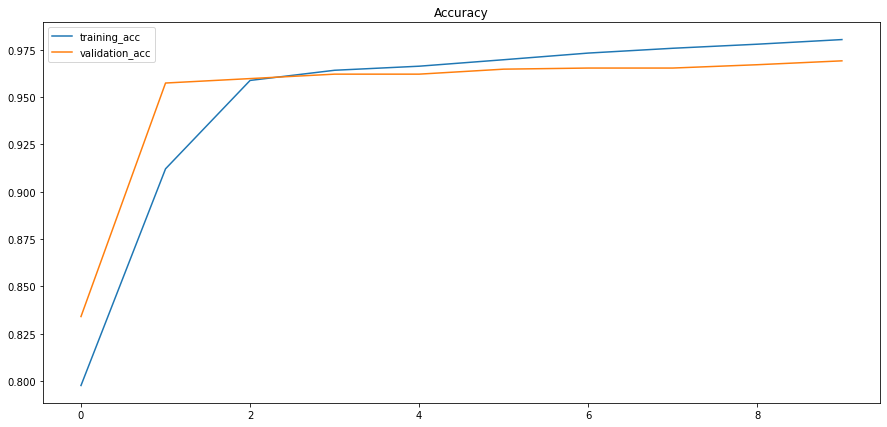

In [19]:
#plot accuracy
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')